## Check Points

- Out Activation
    - tanh to image, x
    - sigmoid to discriminator, x

- Visualized
    - output, x
    - gradients, x
    - loss, x
    - gcam, x
    - activation output, x

In [3]:
%%capture
!pip install git+https://github.com/crimson206/DataLoader@0.1.4
!pip install git+https://github.com/crimson206/DeepLearningDevelopment@0.1.11

## Experiments type 

## Experiments type2

- Long Training1
    Used Experiment0 setup, but 20 epochs
    lr = 2e-4

- Long Training2
    Applied step scheduler. 
    lr, from 5e-4 to 6.4e-05

In [4]:
import torch
import torch.nn as nn
import os
import time
import numpy as np
import json

import matplotlib.pyplot as plt

from torchvision.utils import save_image

import torch.optim as optim
from tqdm import tqdm
from IPython.display import clear_output

from CrimsonDataLoader.dataloads.dataloads import load_mnist, load_cifar, load_celeba
from CrimsonDeepLearning.utils.visualization.loggers import Logger
from CrimsonDeepLearning.utils.visualization.plot_grads import plot_gradient_magnitudes, get_gradient_magnitudes
from CrimsonDeepLearning.utils.visualization.plot_general import plot_dictionary, plot_images
from CrimsonDeepLearning.utils.visualization.analyze_features import generate_gcam, get_activation_visualization
from CrimsonDeepLearning.utils.randomness import seed_everything
from CrimsonDeepLearning.gans.models.dcgan_generator import DCGanGenerator
from CrimsonDeepLearning.gans.models.dcgan_discriminator import DCGanDiscriminator
from CrimsonDeepLearning.utils.initializations import generate_log_resolution_channels
from CrimsonDeepLearning.utils.initializations import collect_statistics, apply_initialization


In [5]:
class Connected(nn.Module):
    def __init__(self, generator, discriminator):
        super(Connected, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
    
    def forward(self, z_latent):
        image = self.generator(z_latent)
        output = self.discriminator(image)
        return output

In [6]:
from tqdm import tqdm
from IPython.display import clear_output
from torchvision.utils import save_image

DATA_DIR = "/notebooks/data"
DEVICE = "cuda"




In [7]:
def custom_init1(shape):
    return torch.randn(shape) * 0.02
def custom_init2(shape):
    return torch.zeros(shape).float()
def custom_init3(shape):
    return torch.randn(shape) * 0.02 + 1

def initialize_model(model):
    apply_initialization(model, torch.nn.ConvTranspose2d, 'weight', custom_init1, custom=True)
    apply_initialization(model, torch.nn.BatchNorm2d, 'weight', custom_init3, custom=True)
    apply_initialization(model, torch.nn.BatchNorm2d, 'bias', custom_init2, custom=True)


In [8]:
def summarize_model_statistics(model):
    summary = {}

    summary["conv_mean"] = np.mean(list(collect_statistics(model, torch.nn.ConvTranspose2d, 'weight', torch.mean).values()))
    summary["conv_std"] = np.mean(list(collect_statistics(model, torch.nn.ConvTranspose2d, 'weight', torch.std).values()))
    summary["norm_mean"] = np.mean(list(collect_statistics(model, torch.nn.BatchNorm2d, 'weight', torch.mean).values()))
    summary["norm_std"] = np.mean(list(collect_statistics(model, torch.nn.BatchNorm2d, 'weight', torch.std).values()))
    summary["norm_bias_mean"] = np.mean(list(collect_statistics(model, torch.nn.BatchNorm2d, 'bias', torch.mean).values()))
    summary["norm_bias_std"] = np.mean(list(collect_statistics(model, torch.nn.BatchNorm2d, 'bias', torch.std).values()))


    return summary

In [30]:
class ExperimentHolder():
    def __init__(self, configs):
        self.generator = None
        self.discriminator = None
        self.connected = None
        self.configs = configs
        self.time = None
        self.repeated = 0

    def do_experiment(self):
        self._do_experiment(**self.configs)

    def _do_experiment(self, batch_size, epochs, interval, n_latent, lr, channel_sizes_G, channel_sizes_D, weight_init, datatype, save_dir):

        if datatype=="mnist":
            _, dataloader, _, _ = load_mnist(DATA_DIR, batch_size, False, resize_to=32)
            in_channel = 1
        elif datatype=="fashionmnist":
            _, dataloader, _, _ = load_mnist(DATA_DIR, batch_size, True, resize_to=32, dataset_type="fashion")
            in_channel = 1
        elif datatype=="cifar":
            _, dataloader, _, _ = load_cifar(DATA_DIR, batch_size, False, 10)
            in_channel = 3
        elif datatype=="celeba":
            _, dataloader= load_celeba("/notebooks/data/celeba/img_align_celeba", '/datasets/celeba_attr/list_attr_celeba.txt', batch_size, resize_to=64)
            in_channel = 3
    
        self.dataloader = dataloader
        generator = DCGanGenerator(n_latent, channel_sizes_G, in_channel)
        discriminator = DCGanDiscriminator(in_channel, channel_sizes_D)
        
        generator.to(DEVICE)
        discriminator.to(DEVICE)

        connected = Connected(generator, discriminator)

        self.generator = generator
        self.discriminator = discriminator
        self.connected = connected

        if weight_init:
            initialize_model(generator)
            initialize_model(discriminator)

        optim_G = torch.optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
        optim_D = torch.optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))

        criterion = nn.BCELoss()

        self.loss_logger = Logger()
        statistics_logger_G = Logger()
        statistics_logger_D = Logger()

        fixed_latent = torch.randn(32, n_latent).to(DEVICE)

        generator.to(DEVICE)
        discriminator.to(DEVICE)

        start_time = time.time()
        
        for _ in range(epochs):
            for i, (image, _) in enumerate(tqdm(dataloader)):

                n_batch = image.shape[0]

                z_latent = torch.randn(n_batch, n_latent).to(DEVICE)
                real_label = torch.ones(n_batch, 1).to(DEVICE)
                fake_label = torch.zeros(n_batch, 1).to(DEVICE)
                
                fake_image = generator.forward(z_latent)

                fake_out = discriminator.forward(fake_image.detach())
                real_out = discriminator.forward(image.to(DEVICE))

                loss_D = 0.5*criterion(fake_out, fake_label)
                loss_D += 0.5*criterion(real_out, real_label)

                discriminator.zero_grad()
                loss_D.backward()
                optim_D.step()

                ###

                fake_image = generator.forward(z_latent)
                fake_out = discriminator.forward(fake_image)

                loss_G = criterion(fake_out, real_label)

                generator.zero_grad()
                loss_G.backward()
                optim_G.step()

                self.loss_logger.batch_step([loss_D.item(), loss_G.item()], labels=["loss_D", "loss_G"])

                done = self.repeated * len(dataloader) + i

                if done%interval==0:

                    clear_output()
                    self.loss_logger.epoch_step()

                    fake_image = generator.forward(fixed_latent)

                    gcam_G = generate_gcam(connected.generator.output_conv, fixed_latent, connected)
                    gcam_G2 = generate_gcam(connected.generator.blocks[2], fixed_latent, connected).mean(dim=1, keepdim=True)
                    gcam_G3 = generate_gcam(connected.generator.blocks[1], fixed_latent, connected).mean(dim=1, keepdim=True)
                    
                    plot_images(fake_image.cpu().detach(), titles=[f"generated_image{i}" for i in range(8)])
                    plot_images(gcam_G.cpu().detach(), titles=[f"grad_cam{i}" for i in range(8)])
                    plot_images(gcam_G2.cpu().detach(), titles=[f"grad_cam_depth1_{i}" for i in range(8)])
                    plot_images(gcam_G3.cpu().detach(), titles=[f"grad_cam_depth2_{i}" for i in range(8)])

                    generator.to("cpu")
                    discriminator.to("cpu")
                    summary_G = summarize_model_statistics(generator)
                    summary_D = summarize_model_statistics(discriminator)
                    grad_G = get_gradient_magnitudes(generator)
                    grad_D = get_gradient_magnitudes(discriminator)
                    generator.to(DEVICE)
                    discriminator.to(DEVICE)

                    plot_gradient_magnitudes(grad_G)
                    plot_gradient_magnitudes(grad_D) 
                    
                    statistics_logger_G.batch_step(np.log10(np.abs(list(summary_G.values()))), labels=list(summary_G.keys()))
                    statistics_logger_D.batch_step(np.log10(np.abs(list(summary_D.values()))), labels=list(summary_D.keys()))

                    os.makedirs(save_dir, exist_ok=True)
                    save_image(fake_image.data[:25], f"{save_dir}/generated_image_{done}.png", nrow=5, normalize=True)
                    save_image(gcam_G.data[:25], f"{save_dir}/gcam_G_{done}.png", nrow=5, normalize=True)
                    plot_dictionary(self.loss_logger.batch_va lues_dict, second_axis_keys=["loss_G"])
                    plot_dictionary(statistics_logger_G.batch_values_dict, title="Param Statistics_G Log")
                    plot_dictionary(statistics_logger_D.batch_values_dict, title="Param Statistics_D Log")

            self.repeated += 1

        configs["time"] = time.time() - start_time
            
        with open(f"{save_dir}/configs.json", 'w') as f:
            json.dump(self.configs, f, indent=4)



/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

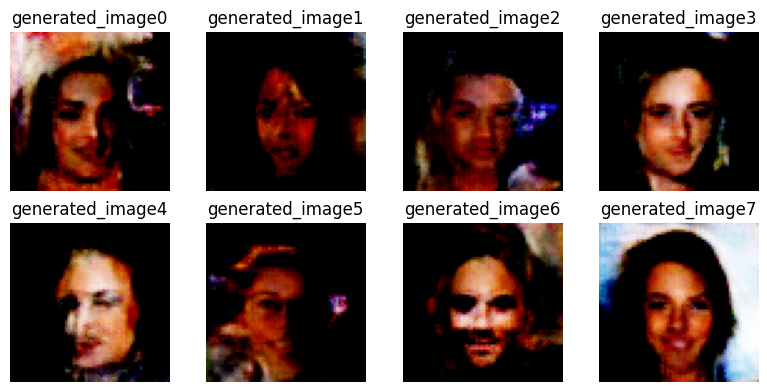

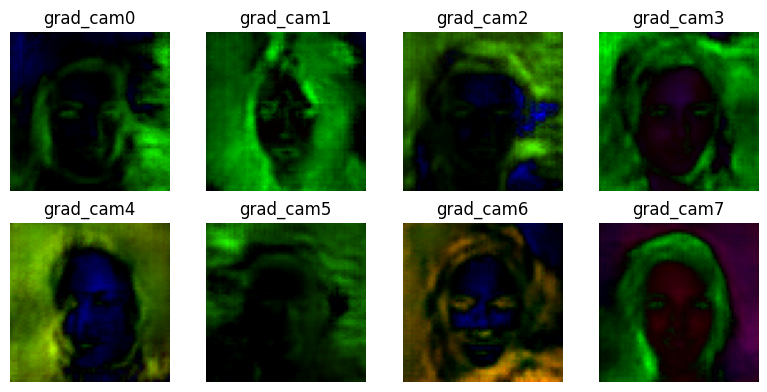

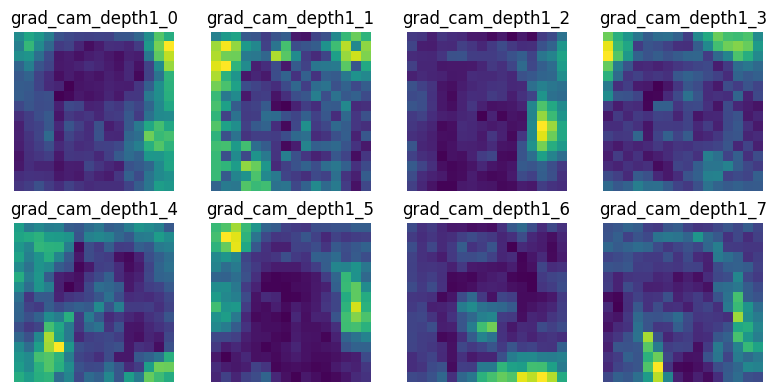

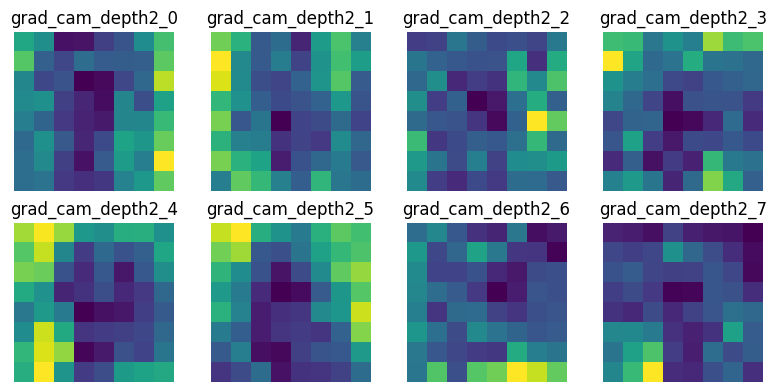

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


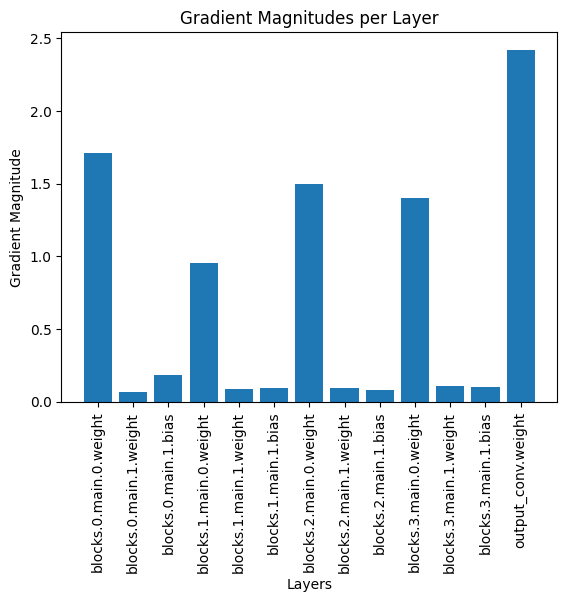

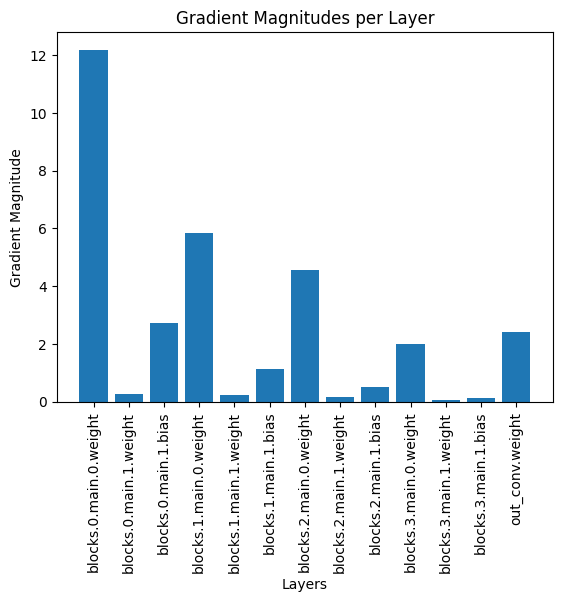

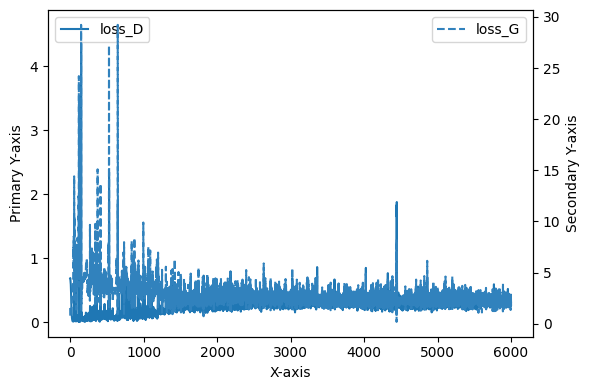

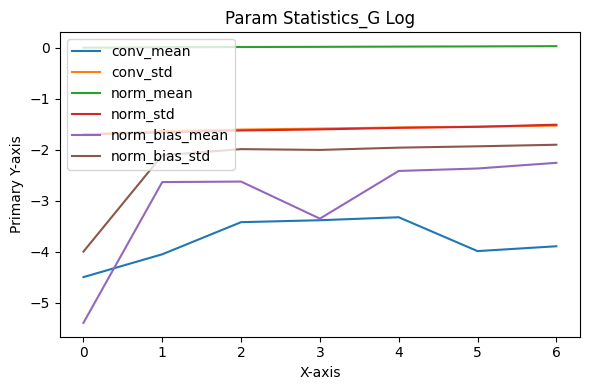

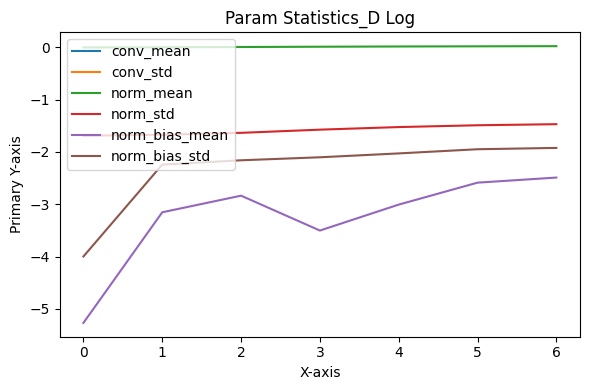

100%|██████████| 3166/3166 [23:39<00:00,  2.23it/s]


In [32]:
channel_sizes_G = generate_log_resolution_channels(4, 512, 0)
channel_sizes_D = generate_log_resolution_channels(4, 512, 0, reverse=True)

configs = {
    "batch_size":64,
    "epochs":2,
    "interval":1000,
    "n_latent":64,
    "lr":0.0001,
    "channel_sizes_G":channel_sizes_G,
    "channel_sizes_D":channel_sizes_D,
    "weight_init":True,
    "datatype":"celeba",
    "save_dir":"dcgan_experiment/experiment_celeba",
}

channel_sizes_D, channel_sizes_G

exp_h = ExperimentHolder(configs)
exp_h.do_experiment()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


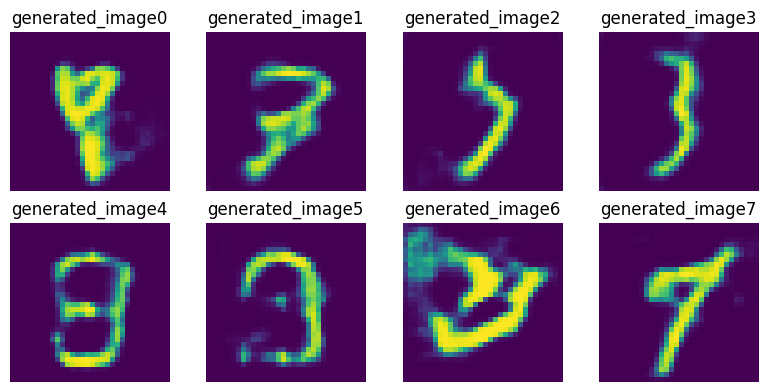

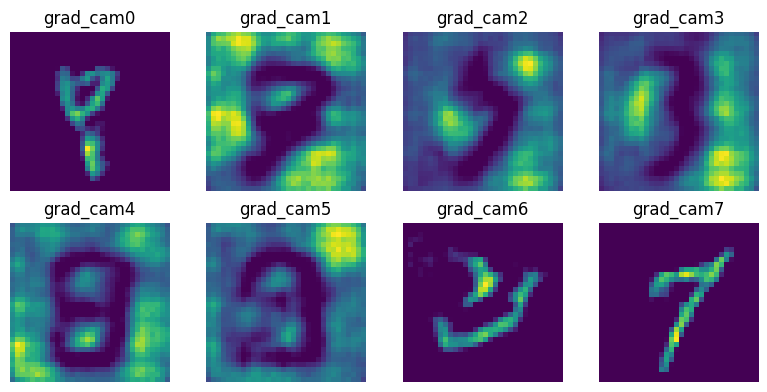

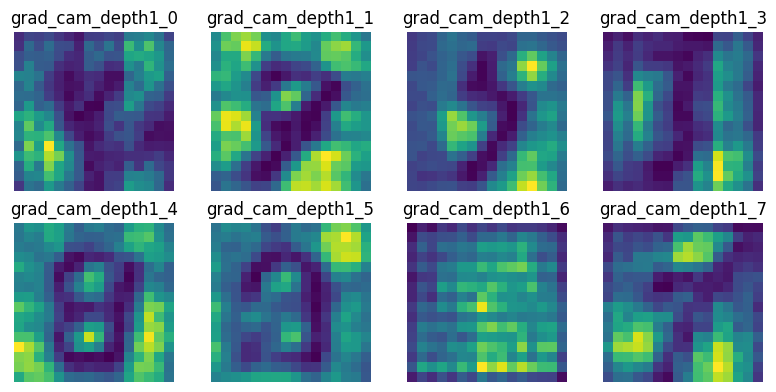

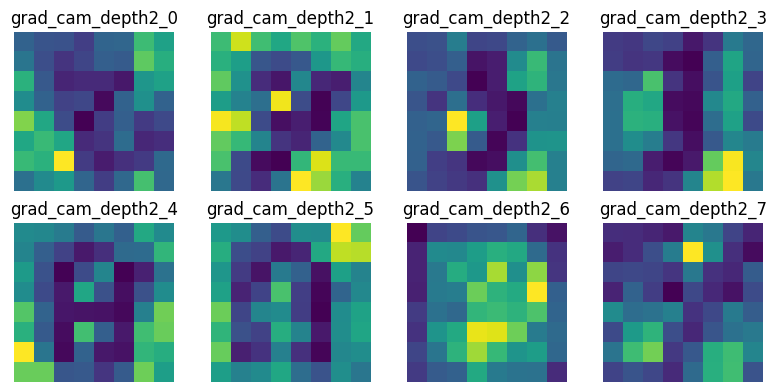

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


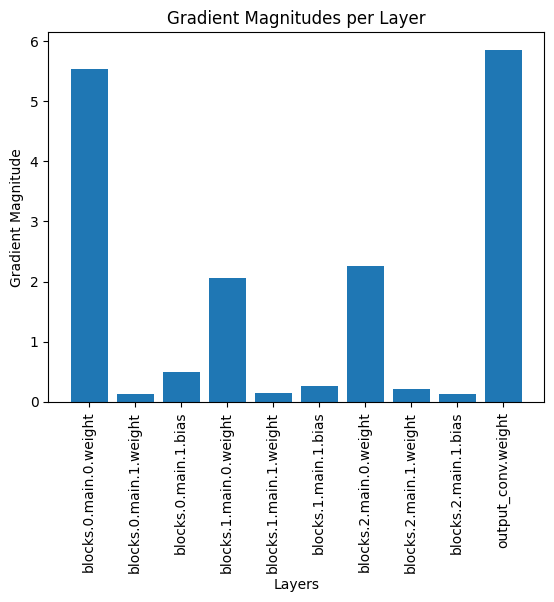

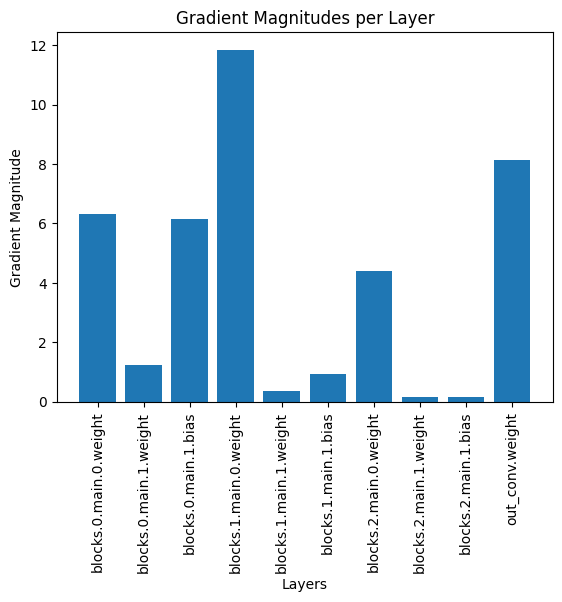

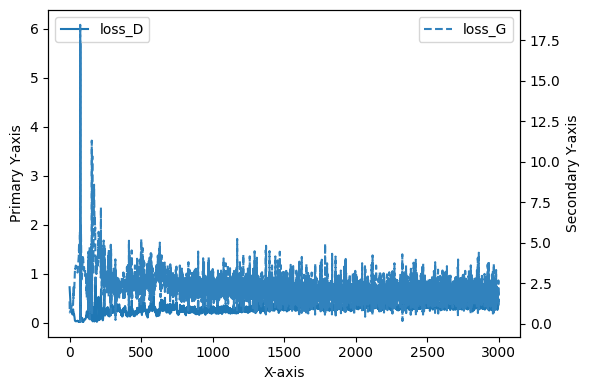

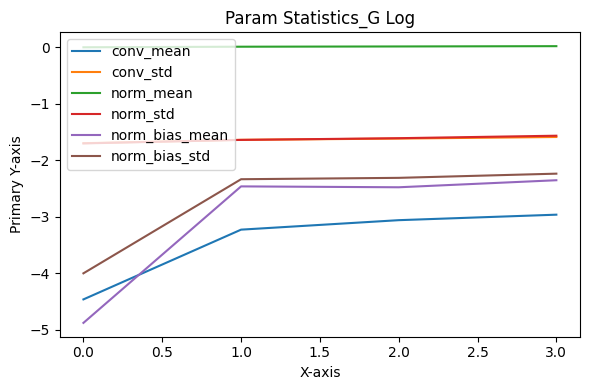

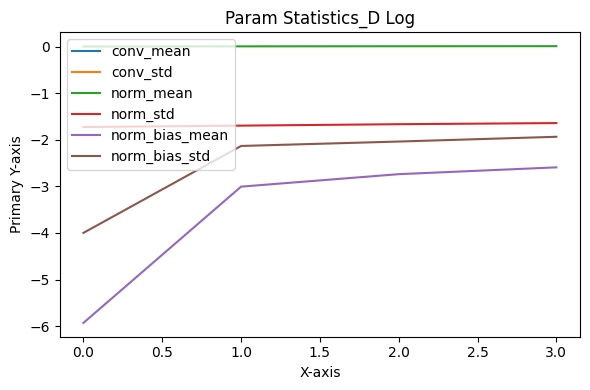

100%|██████████| 938/938 [01:34<00:00,  9.97it/s]


In [33]:
channel_sizes_G = generate_log_resolution_channels(3, 512, 0)
channel_sizes_D = generate_log_resolution_channels(3, 512, 0, reverse=True)

configs = {
    "batch_size":64,
    "epochs":4,
    "interval":1000,
    "n_latent":64,
    "lr":0.0001,
    "channel_sizes_G":channel_sizes_G,
    "channel_sizes_D":channel_sizes_D,
    "weight_init":True,
    "datatype":"mnist",
    "save_dir":"dcgan_experiment/experiment_mnist",
}

channel_sizes_D, channel_sizes_G

exp_h = ExperimentHolder(configs)
exp_h.do_experiment()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


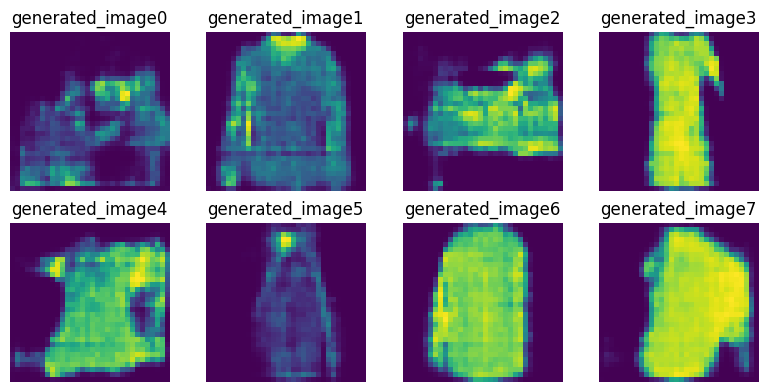

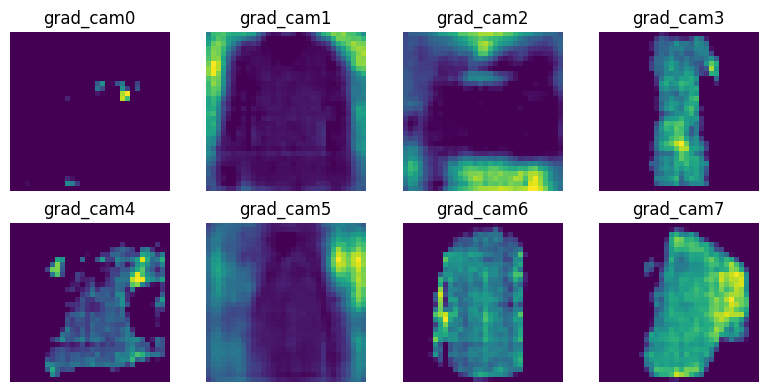

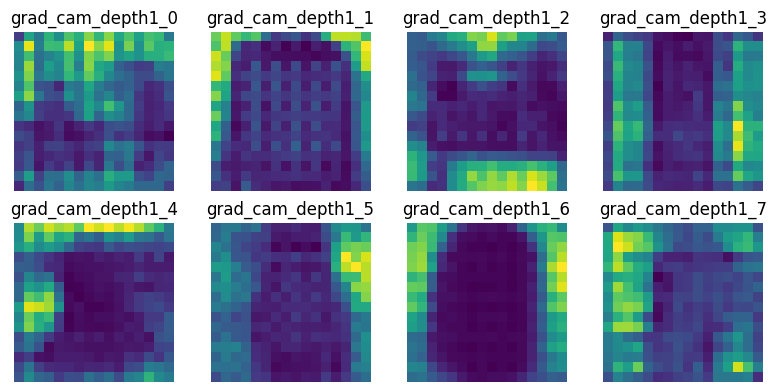

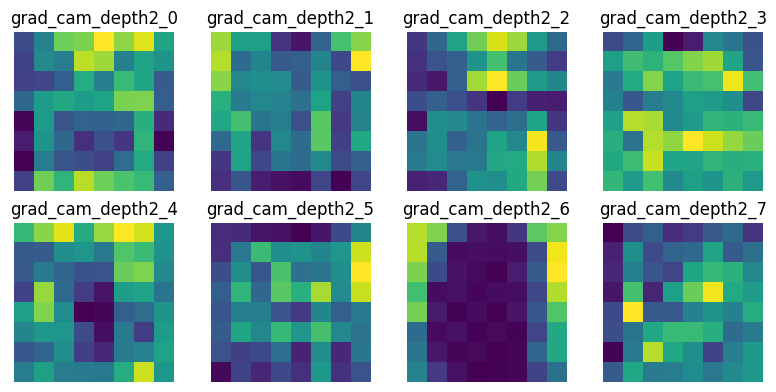

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


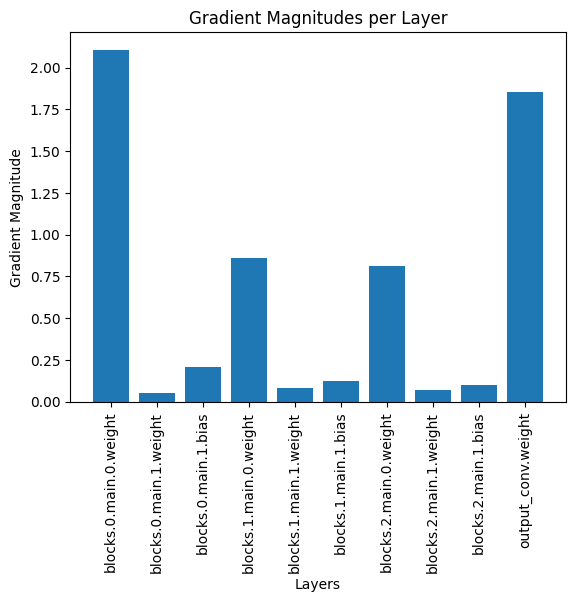

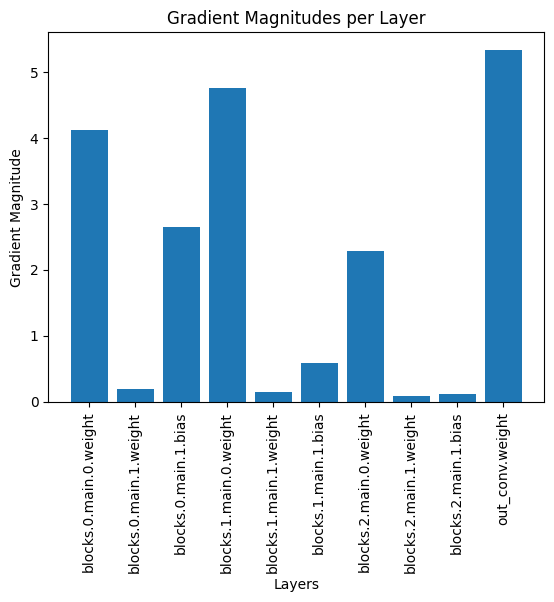

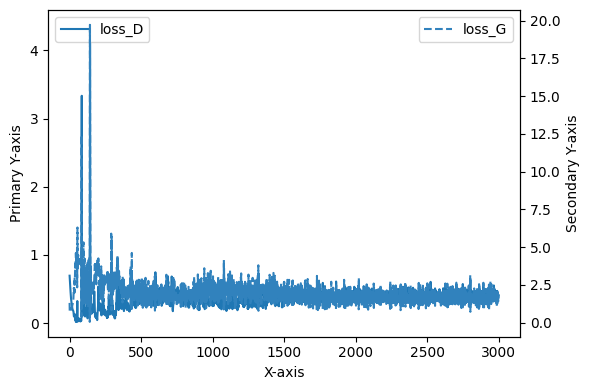

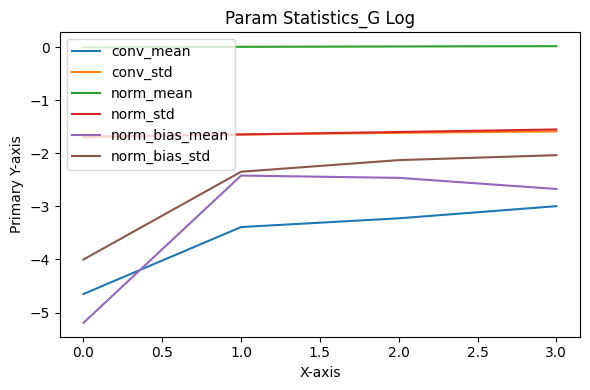

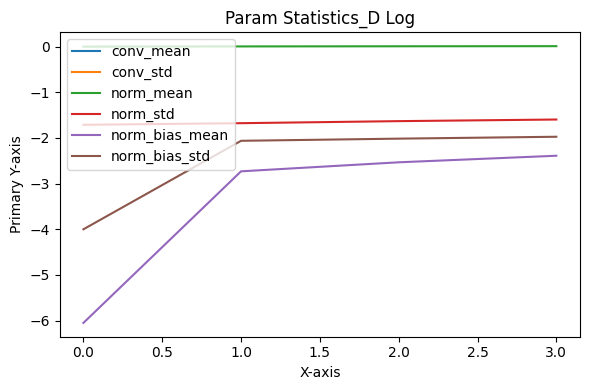

100%|██████████| 938/938 [01:34<00:00,  9.94it/s]


In [34]:
channel_sizes_G = generate_log_resolution_channels(3, 512, 0)
channel_sizes_D = generate_log_resolution_channels(3, 512, 0, reverse=True)

configs = {
    "batch_size":64,
    "epochs":4,
    "interval":1000,
    "n_latent":64,
    "lr":0.0001,
    "channel_sizes_G":channel_sizes_G,
    "channel_sizes_D":channel_sizes_D,
    "weight_init":True,
    "datatype":"fashionmnist",
    "save_dir":"dcgan_experiment_text/experiment_fashionmnist",
}

channel_sizes_D, channel_sizes_G

exp_h = ExperimentHolder(configs)
exp_h.do_experiment()

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

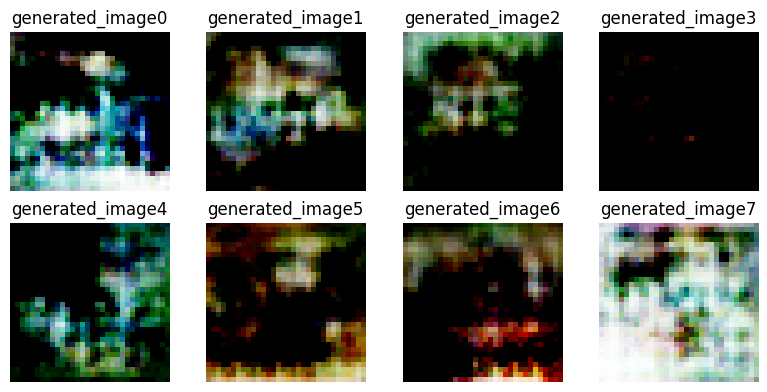

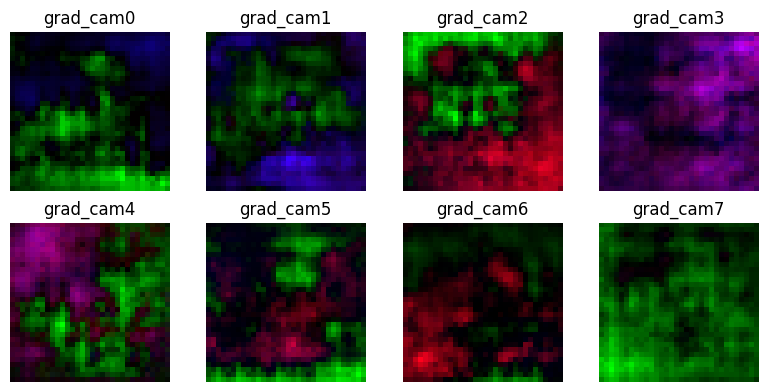

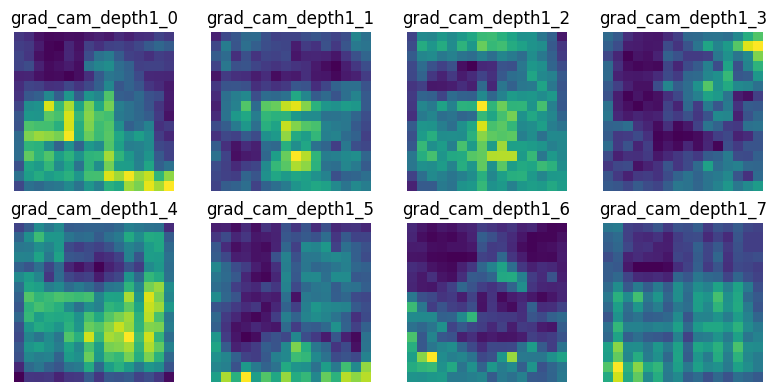

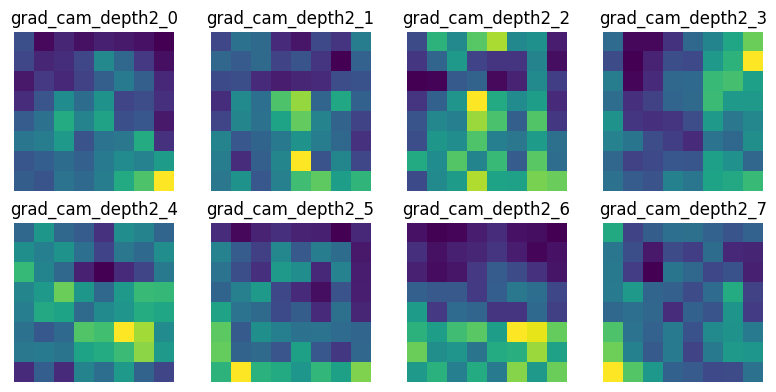

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


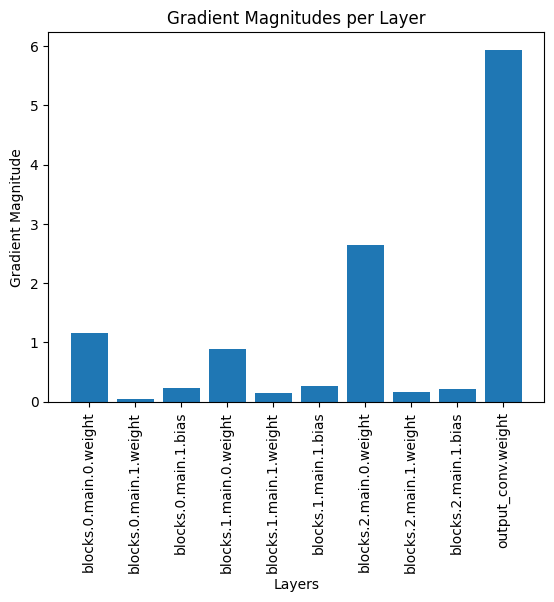

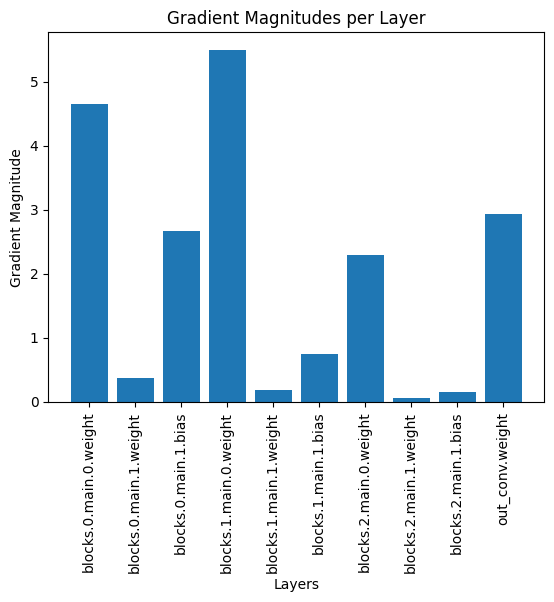

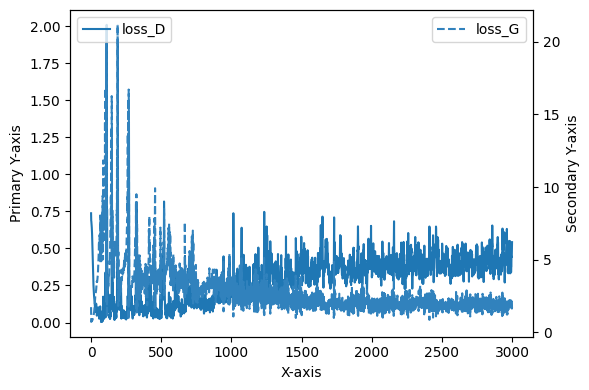

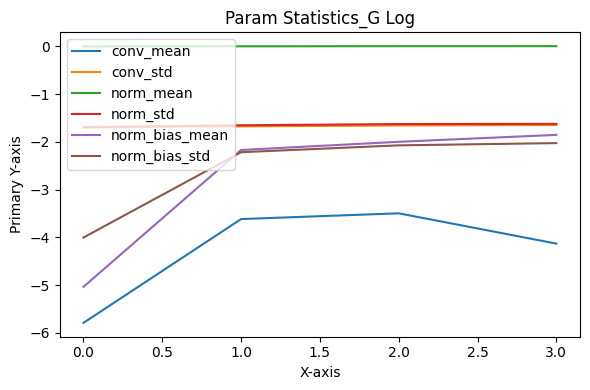

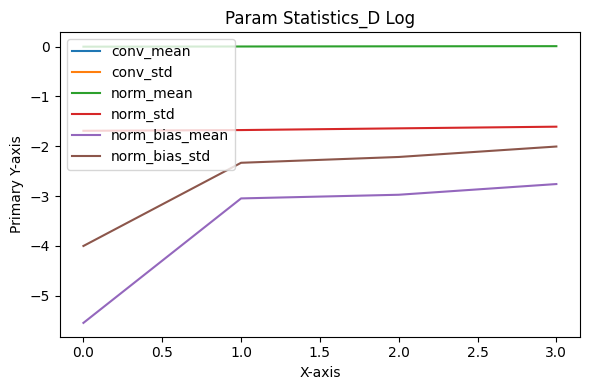

100%|██████████| 782/782 [01:19<00:00,  9.80it/s]


In [35]:
channel_sizes_G = generate_log_resolution_channels(3, 512, 0)
channel_sizes_D = generate_log_resolution_channels(3, 512, 0, reverse=True)

configs = {
    "batch_size":64,
    "epochs":4,
    "interval":1000,
    "n_latent":64,
    "lr":0.0001,
    "channel_sizes_G":channel_sizes_G,
    "channel_sizes_D":channel_sizes_D,
    "weight_init":True,
    "datatype":"cifar",
    "save_dir":"dcgan_experiment_text/experiment_cifar",
}

channel_sizes_D, channel_sizes_G

exp_h = ExperimentHolder(configs)
exp_h.do_experiment()